Starting RL Training...
Goals placed at: [(8, 0), (0, 1), (3, 7)]
Episode 100/1500 - Avg Reward: 13.93 - Success Rate: 57.0% - Epsilon: 0.606
Episode 200/1500 - Avg Reward: 60.63 - Success Rate: 99.0% - Epsilon: 0.367
Episode 300/1500 - Avg Reward: 65.91 - Success Rate: 100.0% - Epsilon: 0.222
Episode 400/1500 - Avg Reward: 66.97 - Success Rate: 100.0% - Epsilon: 0.135
Episode 500/1500 - Avg Reward: 67.47 - Success Rate: 100.0% - Epsilon: 0.082
Episode 600/1500 - Avg Reward: 67.73 - Success Rate: 100.0% - Epsilon: 0.049
Episode 700/1500 - Avg Reward: 67.98 - Success Rate: 100.0% - Epsilon: 0.030
Episode 800/1500 - Avg Reward: 67.96 - Success Rate: 100.0% - Epsilon: 0.018
Episode 900/1500 - Avg Reward: 68.01 - Success Rate: 100.0% - Epsilon: 0.011
Episode 1000/1500 - Avg Reward: 68.04 - Success Rate: 100.0% - Epsilon: 0.010
Episode 1100/1500 - Avg Reward: 68.04 - Success Rate: 100.0% - Epsilon: 0.010
Episode 1200/1500 - Avg Reward: 68.06 - Success Rate: 100.0% - Epsilon: 0.010
Episode 1

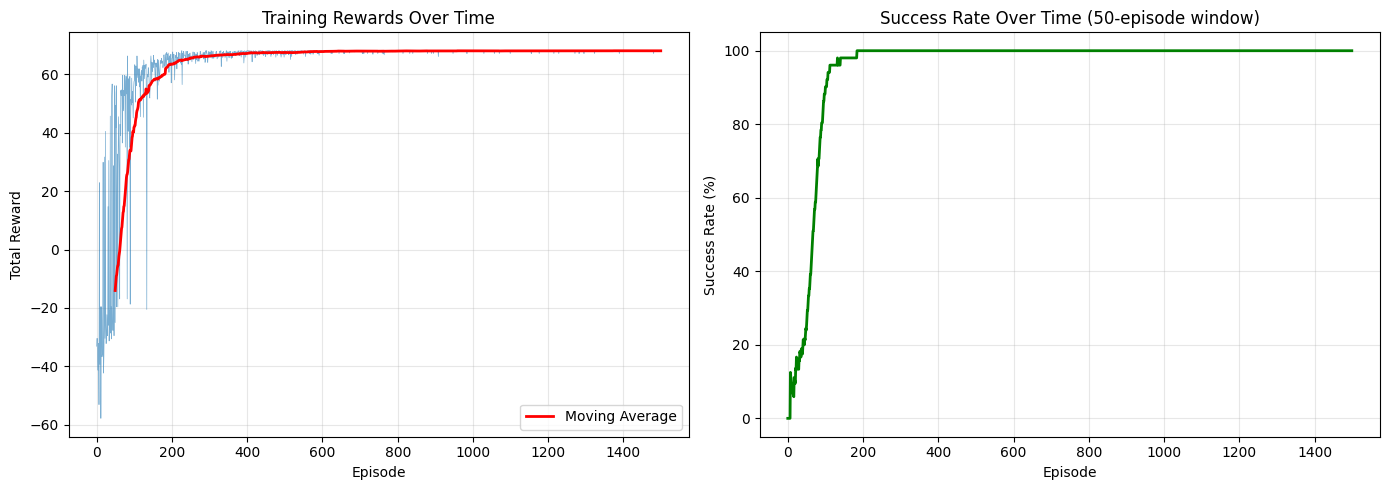


Visualizing trained agent...
Creating visualization frames...
Saving GIF...
GIF saved as 'rl_agent_navigation.gif'

Displaying agent navigation...



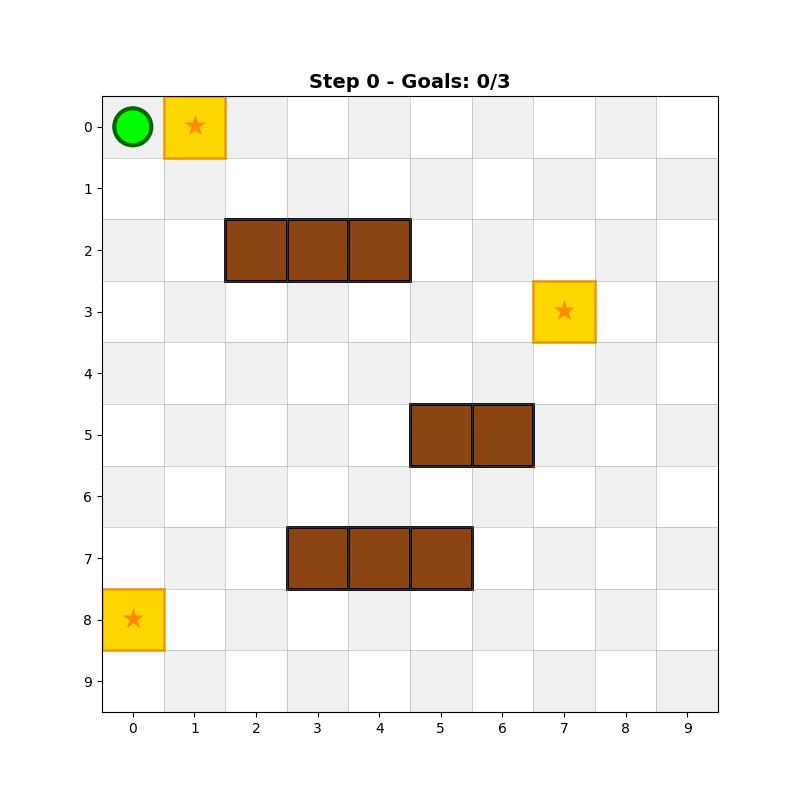

GIF is now embedded in the notebook!

Showing step-by-step progression...


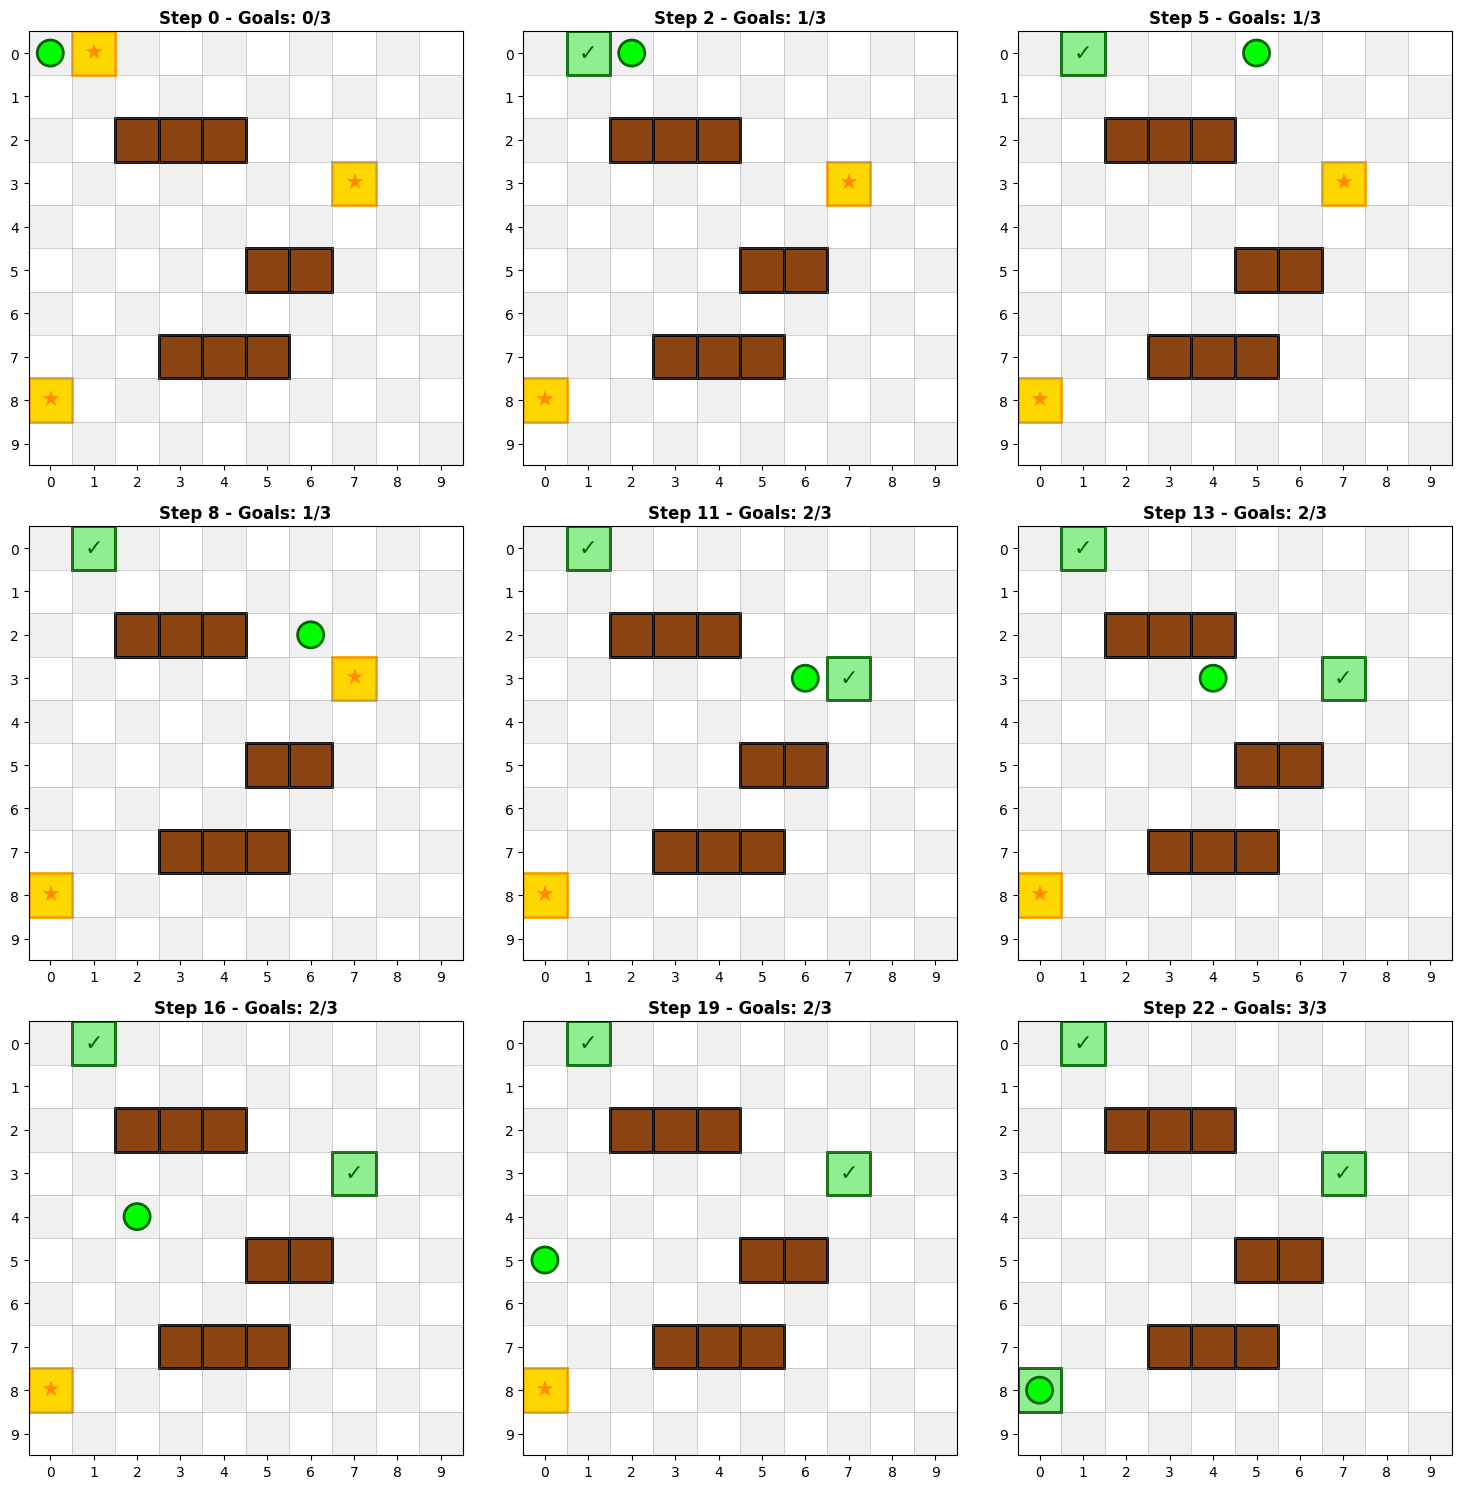


Agent completed the task in 23 steps!
Goals collected: 3/3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML

class GridWorldRL:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size

        # Define obstacles (fixed)
        self.obstacles = [(2, 2), (2, 3), (2, 4), (5, 5), (5, 6), (7, 3), (7, 4), (7, 5)]

        # Generate random goal positions (avoid obstacles and starting position)
        self.goals = self._generate_random_goals(num_goals=3)
        print(f"Goals placed at: {self.goals}")

        self.reset()

        # Actions: up, down, left, right
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.n_actions = len(self.actions)

        # Q-table: state (including goals collected) -> action -> Q-value
        self.q_table = {}
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def _generate_random_goals(self, num_goals=3):
        """Generate random goal positions avoiding obstacles and start"""
        goals = []
        forbidden = set(self.obstacles + [(0, 0)])

        while len(goals) < num_goals:
            x = np.random.randint(0, self.grid_size)
            y = np.random.randint(0, self.grid_size)
            if (x, y) not in forbidden and (x, y) not in goals:
                goals.append((x, y))

        return goals

    def reset(self):
        self.agent_pos = [0, 0]
        self.collected_goals = set()
        return self.get_state()

    def get_state(self):
        # State includes position and which goals have been collected
        return (tuple(self.agent_pos), frozenset(self.collected_goals))

    def is_valid_pos(self, pos):
        x, y = pos
        return (0 <= x < self.grid_size and
                0 <= y < self.grid_size and
                tuple(pos) not in self.obstacles)

    def step(self, action_idx):
        action = self.actions[action_idx]
        new_pos = [self.agent_pos[0] + action[0], self.agent_pos[1] + action[1]]

        reward = -0.1  # Small penalty for each step
        done = False

        # Check if new position is valid
        if self.is_valid_pos(new_pos):
            self.agent_pos = new_pos

            # Check if agent reached a goal
            if tuple(self.agent_pos) in self.goals and tuple(self.agent_pos) not in self.collected_goals:
                self.collected_goals.add(tuple(self.agent_pos))
                reward = 10.0  # Big reward for reaching a goal

                # Check if all goals collected
                if len(self.collected_goals) == len(self.goals):
                    reward = 50.0  # Huge reward for completing all goals
                    done = True
        else:
            # Hit obstacle or wall
            reward = -1.0

        return self.get_state(), reward, done

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state):
        # Epsilon-greedy policy
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.n_actions)]
            return np.argmax(q_values)

    def update_q_table(self, state, action, reward, next_state):
        current_q = self.get_q_value(state, action)
        max_next_q = max([self.get_q_value(next_state, a) for a in range(self.n_actions)])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[(state, action)] = new_q

    def train(self, episodes=1000, max_steps=200):
        rewards_history = []
        success_history = []

        for episode in range(episodes):
            state = self.reset()
            total_reward = 0

            for step in range(max_steps):
                action = self.choose_action(state)
                next_state, reward, done = self.step(action)

                self.update_q_table(state, action, reward, next_state)

                state = next_state
                total_reward += reward

                if done:
                    success_history.append(1)
                    break
            else:
                success_history.append(0)

            rewards_history.append(total_reward)

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                success_rate = np.mean(success_history[-100:]) * 100
                print(f"Episode {episode + 1}/{episodes} - Avg Reward: {avg_reward:.2f} - Success Rate: {success_rate:.1f}% - Epsilon: {self.epsilon:.3f}")

        return rewards_history, success_history

    def visualize_episode(self, max_steps=100):
        """Run one episode with the trained agent and return path"""
        state = self.reset()
        path = [self.agent_pos.copy()]
        goals_collected_timeline = [self.collected_goals.copy()]

        for _ in range(max_steps):
            # Use greedy policy (no exploration)
            q_values = [self.get_q_value(state, a) for a in range(self.n_actions)]
            action = np.argmax(q_values)

            state, reward, done = self.step(action)
            path.append(self.agent_pos.copy())
            goals_collected_timeline.append(self.collected_goals.copy())

            if done:
                break

        return path, goals_collected_timeline

# Train the agent
print("Starting RL Training...")
env = GridWorldRL(grid_size=10)
rewards, successes = env.train(episodes=1500, max_steps=200)

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot rewards
ax1.plot(rewards, alpha=0.6, linewidth=0.5)
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(rewards)), moving_avg, color='red', linewidth=2, label='Moving Average')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Rewards Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot success rate
success_rate = [np.mean(successes[max(0, i-50):i+1]) * 100 for i in range(len(successes))]
ax2.plot(success_rate, color='green', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Success Rate Over Time (50-episode window)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize the trained agent
print("\nVisualizing trained agent...")
path, goals_timeline = env.visualize_episode(max_steps=100)

def draw_grid(agent_pos, collected_goals, step_num):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Color cells (checkered pattern)
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i % 2 + j % 2) % 2 == 0:
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor='#f0f0f0', edgecolor='none'))

    # Draw obstacles (brown)
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                               facecolor='#8b4513', edgecolor='black', linewidth=2))

    # Draw goals
    for goal in env.goals:
        if tuple(goal) in collected_goals:
            # Collected goal (light green with checkmark)
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#90EE90', edgecolor='darkgreen', linewidth=2))
            ax.text(goal[1], goal[0], '✓', fontsize=20, ha='center', va='center',
                   color='darkgreen', weight='bold')
        else:
            # Uncollected goal (gold star)
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#FFD700', edgecolor='orange', linewidth=2))
            ax.text(goal[1], goal[0], '★', fontsize=20, ha='center', va='center',
                   color='darkorange')

    # Draw agent (bright green circle)
    circle = plt.Circle((agent_pos[1], agent_pos[0]), 0.3,
                       facecolor='#00FF00', edgecolor='darkgreen', linewidth=3, zorder=10)
    ax.add_patch(circle)

    # Draw grid lines
    for i in range(env.grid_size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)

    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_title(f'Step {step_num} - Goals: {len(collected_goals)}/{len(env.goals)}',
                fontsize=14, weight='bold')
    ax.grid(False)

    return fig

# Save frames as GIF
print("Creating visualization frames...")
import imageio
frames = []

# Show every 2nd step to make GIF smaller
for i in range(0, len(path), 2):
    fig = draw_grid(path[i], goals_timeline[i], i)

    # Convert plot to image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frames.append(image[:, :, :3])  # Remove alpha channel
    plt.close(fig)

# Save as GIF
print("Saving GIF...")
imageio.mimsave('rl_agent_navigation.gif', frames, fps=5, loop=0)
print("GIF saved as 'rl_agent_navigation.gif'")

# Embed the GIF in the notebook permanently
print("\nDisplaying agent navigation...")
from IPython.display import Image, display
import base64

# Read the GIF and encode it as base64
with open('rl_agent_navigation.gif', 'rb') as f:
    gif_data = f.read()
    gif_base64 = base64.b64encode(gif_data).decode()

# Display using HTML with embedded base64 data
from IPython.display import HTML
display(HTML(f'<img src="data:image/gif;base64,{gif_base64}" />'))
print("GIF is now embedded in the notebook!")

# Also create a figure showing multiple steps
print("\nShowing step-by-step progression...")
num_snapshots = min(9, len(path))
step_indices = np.linspace(0, len(path)-1, num_snapshots, dtype=int)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, step_idx in enumerate(step_indices):
    ax = axes[idx]
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Checkered background
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i % 2 + j % 2) % 2 == 0:
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor='#f0f0f0', edgecolor='none'))

    # Obstacles
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                               facecolor='#8b4513', edgecolor='black', linewidth=2))

    # Goals
    for goal in env.goals:
        if tuple(goal) in goals_timeline[step_idx]:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#90EE90', edgecolor='darkgreen', linewidth=2))
            ax.text(goal[1], goal[0], '✓', fontsize=16, ha='center', va='center',
                   color='darkgreen', weight='bold')
        else:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#FFD700', edgecolor='orange', linewidth=2))
            ax.text(goal[1], goal[0], '★', fontsize=16, ha='center', va='center',
                   color='darkorange')

    # Agent
    circle = plt.Circle((path[step_idx][1], path[step_idx][0]), 0.3,
                       facecolor='#00FF00', edgecolor='darkgreen', linewidth=2, zorder=10)
    ax.add_patch(circle)

    # Grid lines
    for i in range(env.grid_size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)

    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_title(f'Step {step_idx} - Goals: {len(goals_timeline[step_idx])}/{len(env.goals)}',
                fontsize=12, weight='bold')
    ax.grid(False)

plt.tight_layout()
plt.show()

print(f"\nAgent completed the task in {len(path)} steps!")
print(f"Goals collected: {len(goals_timeline[-1])}/{len(env.goals)}")

Starting RL Training with FIXED STATE REPRESENTATION!
State now includes: position region + direction to goal + distance + progress
This allows the agent to learn goal-seeking behavior that generalizes!

Episode 100/2000 - Avg Reward: -7.29 - Success Rate: 21.0% - Epsilon: 0.951
Episode 200/2000 - Avg Reward: 4.46 - Success Rate: 34.0% - Epsilon: 0.905
Episode 300/2000 - Avg Reward: 19.90 - Success Rate: 48.0% - Epsilon: 0.861
Episode 400/2000 - Avg Reward: 37.05 - Success Rate: 69.0% - Epsilon: 0.819
Episode 500/2000 - Avg Reward: 44.96 - Success Rate: 81.0% - Epsilon: 0.779
Episode 600/2000 - Avg Reward: 52.18 - Success Rate: 86.0% - Epsilon: 0.741
Episode 700/2000 - Avg Reward: 58.37 - Success Rate: 93.0% - Epsilon: 0.705
Episode 800/2000 - Avg Reward: 59.37 - Success Rate: 93.0% - Epsilon: 0.670
Episode 900/2000 - Avg Reward: 60.19 - Success Rate: 93.0% - Epsilon: 0.638
Episode 1000/2000 - Avg Reward: 59.63 - Success Rate: 93.0% - Epsilon: 0.606
Episode 1100/2000 - Avg Reward: 63.3

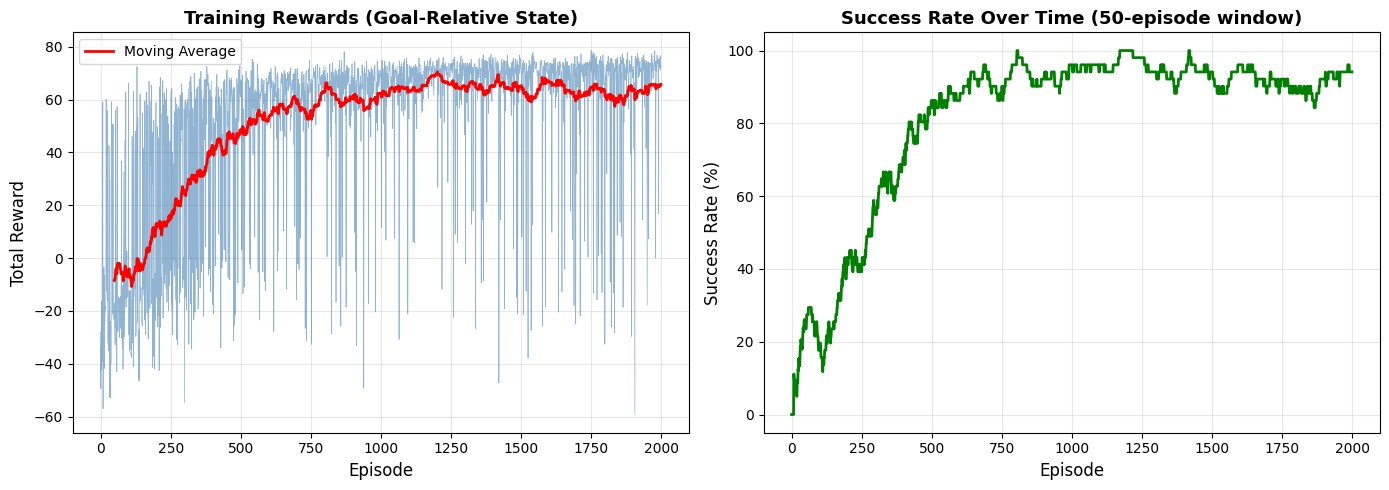


Visualizing trained agent with NEW RANDOM goals...
Goals for this episode: [(3, 2), (2, 9), (1, 0)]
Path length: 14 steps
Creating visualization frames...
Saving GIF...
GIF saved as 'rl_agent_fixed.gif'

Displaying agent navigation...



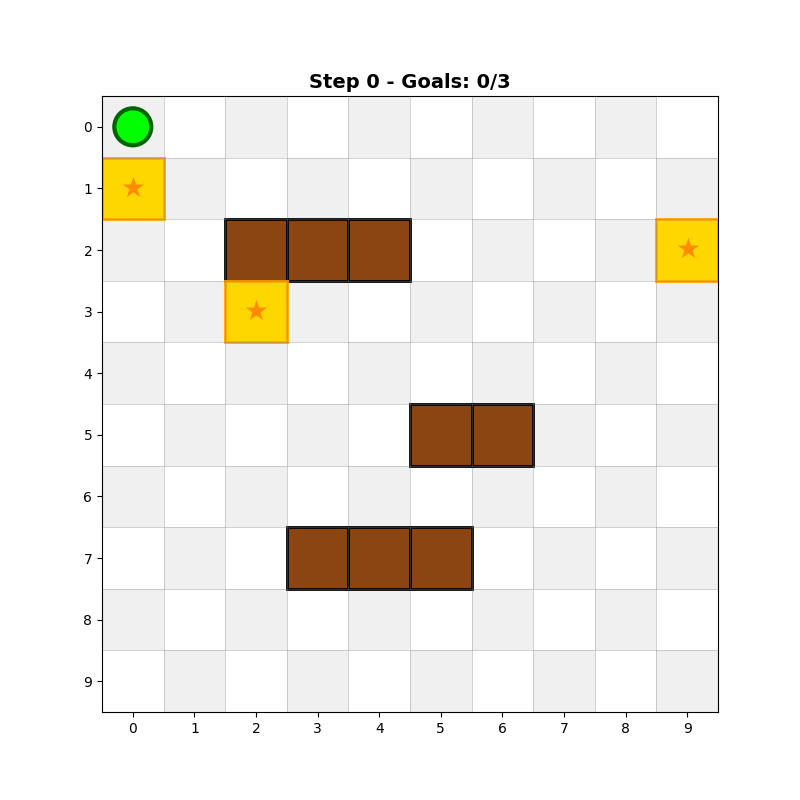

GIF is now embedded in the notebook!

Showing step-by-step progression...


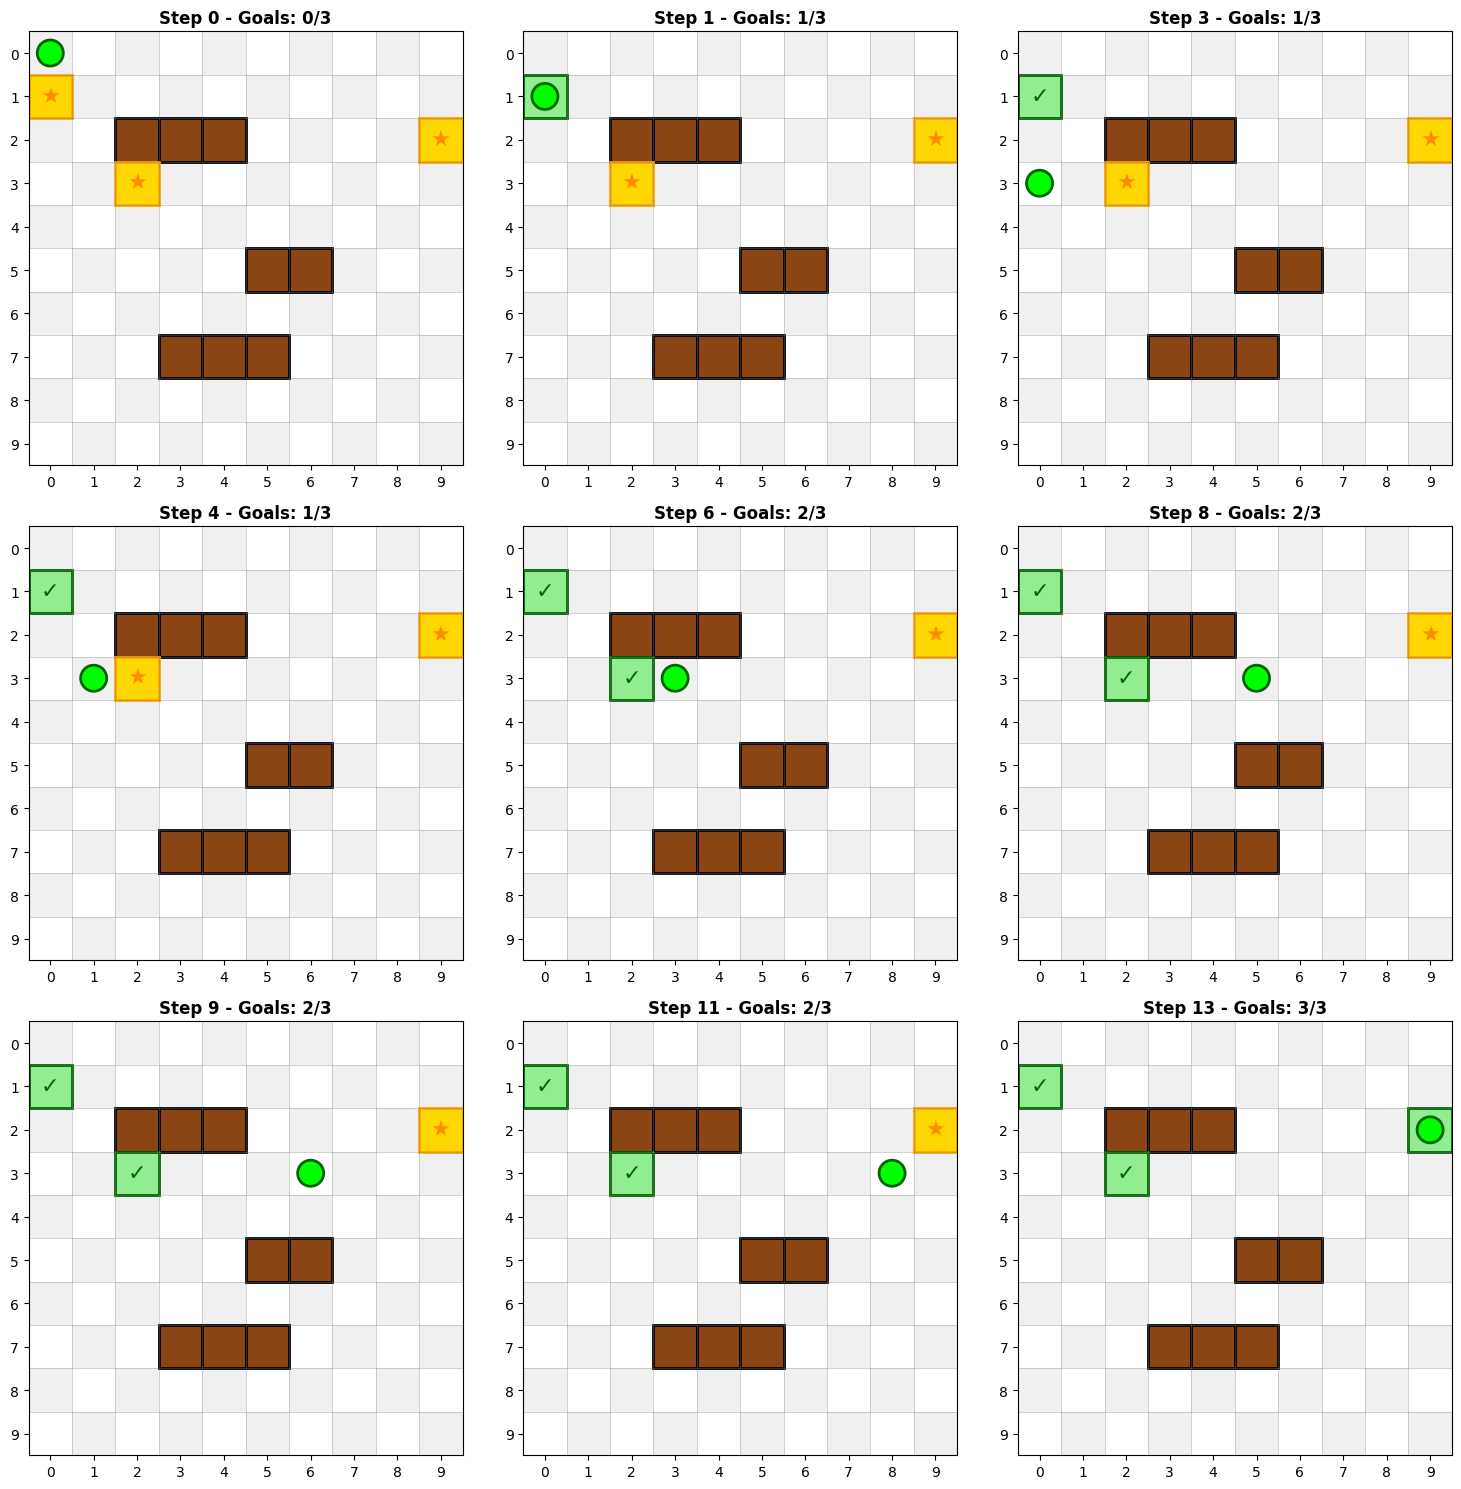


Agent completed the task in 14 steps!
Goals collected: 3/3

✓ FIXED: State representation now includes goal-relative information!
  - Direction to nearest goal (8 directions)
  - Distance bucket to goal (near/medium/far)
  - Position region (5x5 grid)
  - Number of goals collected

This allows Q-learning to generalize across episodes with different goal locations!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import imageio

class DynamicGridWorldRL:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size

        # Define obstacles (fixed)
        self.obstacles = [(2, 2), (2, 3), (2, 4), (5, 5), (5, 6), (7, 3), (7, 4), (7, 5)]

        # Goals will change every episode
        self.goals = []
        self.collected_goals = set()
        self.agent_pos = [0, 0]

        # Actions: up, down, left, right
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.n_actions = len(self.actions)

        # Q-table: state (position + goal-relative info) -> action -> Q-value
        self.q_table = {}
        self.learning_rate = 0.1
        self.discount_factor = 0.95
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01

    def _generate_random_goals(self, num_goals=3):
        """Generate random goal positions avoiding obstacles and start"""
        goals = []
        forbidden = set(self.obstacles + [(0, 0)])

        while len(goals) < num_goals:
            x = np.random.randint(0, self.grid_size)
            y = np.random.randint(0, self.grid_size)
            if (x, y) not in forbidden and (x, y) not in goals:
                goals.append((x, y))

        return goals

    def get_nearest_uncollected_goal(self):
        """Find the nearest uncollected goal"""
        uncollected = [g for g in self.goals if tuple(g) not in self.collected_goals]
        if not uncollected:
            return None

        distances = [abs(self.agent_pos[0] - g[0]) + abs(self.agent_pos[1] - g[1])
                    for g in uncollected]
        return uncollected[np.argmin(distances)]

    def get_state(self):
        """
        State representation includes:
        1. Agent position (discretized into regions)
        2. Relative direction to nearest uncollected goal
        3. Distance bucket to nearest goal
        4. Number of goals collected
        """
        x, y = self.agent_pos

        # Get nearest uncollected goal
        nearest_goal = self.get_nearest_uncollected_goal()

        if nearest_goal is None:
            # All goals collected
            return (x, y, 0, 0, 0, len(self.collected_goals))

        # Calculate relative position to goal (discretized)
        dx = nearest_goal[0] - x
        dy = nearest_goal[1] - y

        # Direction encoding: 8 directions + same position
        if dx == 0 and dy == 0:
            direction = 0
        elif dx > 0 and dy == 0:
            direction = 1  # down
        elif dx < 0 and dy == 0:
            direction = 2  # up
        elif dx == 0 and dy > 0:
            direction = 3  # right
        elif dx == 0 and dy < 0:
            direction = 4  # left
        elif dx > 0 and dy > 0:
            direction = 5  # down-right
        elif dx > 0 and dy < 0:
            direction = 6  # down-left
        elif dx < 0 and dy > 0:
            direction = 7  # up-right
        else:
            direction = 8  # up-left

        # Distance bucket (near: <3, medium: 3-6, far: >6)
        manhattan_dist = abs(dx) + abs(dy)
        if manhattan_dist < 3:
            dist_bucket = 0
        elif manhattan_dist < 6:
            dist_bucket = 1
        else:
            dist_bucket = 2

        # Discretize position into 5x5 regions to reduce state space
        region_x = min(x // 2, 4)
        region_y = min(y // 2, 4)

        return (region_x, region_y, direction, dist_bucket, len(self.collected_goals))

    def reset(self):
        """Reset environment with NEW random goals every episode"""
        self.agent_pos = [0, 0]
        self.goals = self._generate_random_goals(num_goals=3)
        self.collected_goals = set()
        return self.get_state()

    def is_valid_pos(self, pos):
        x, y = pos
        return (0 <= x < self.grid_size and
                0 <= y < self.grid_size and
                tuple(pos) not in self.obstacles)

    def step(self, action_idx):
        action = self.actions[action_idx]
        new_pos = [self.agent_pos[0] + action[0], self.agent_pos[1] + action[1]]

        # Get distance to nearest goal before move
        nearest_goal = self.get_nearest_uncollected_goal()
        old_dist = float('inf')
        if nearest_goal is not None:
            old_dist = abs(self.agent_pos[0] - nearest_goal[0]) + abs(self.agent_pos[1] - nearest_goal[1])

        reward = -0.1  # Small penalty for each step
        done = False

        # Check if new position is valid
        if self.is_valid_pos(new_pos):
            self.agent_pos = new_pos

            # Reward shaping: encourage moving toward nearest goal
            if nearest_goal is not None:
                new_dist = abs(self.agent_pos[0] - nearest_goal[0]) + abs(self.agent_pos[1] - nearest_goal[1])
                if new_dist < old_dist:
                    reward += 0.5  # Bonus for getting closer
                elif new_dist > old_dist:
                    reward -= 0.3  # Penalty for moving away

            # Check if agent reached a goal
            if tuple(self.agent_pos) in self.goals and tuple(self.agent_pos) not in self.collected_goals:
                self.collected_goals.add(tuple(self.agent_pos))
                reward = 10.0  # Big reward for reaching a goal

                # Check if all goals collected
                if len(self.collected_goals) == len(self.goals):
                    reward = 50.0  # Huge reward for completing all goals
                    done = True
        else:
            # Hit obstacle or wall
            reward = -1.0

        return self.get_state(), reward, done

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state, use_epsilon=True):
        # Epsilon-greedy policy
        if use_epsilon and np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = [self.get_q_value(state, a) for a in range(self.n_actions)]
            # Add small random noise to break ties when all Q-values are equal
            q_values = np.array(q_values) + np.random.randn(self.n_actions) * 0.001
            return np.argmax(q_values)

    def update_q_table(self, state, action, reward, next_state):
        current_q = self.get_q_value(state, action)
        max_next_q = max([self.get_q_value(next_state, a) for a in range(self.n_actions)])
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[(state, action)] = new_q

    def train(self, episodes=2000, max_steps=200):
        rewards_history = []
        success_history = []

        for episode in range(episodes):
            state = self.reset()  # NEW GOALS EVERY EPISODE!
            total_reward = 0

            for step in range(max_steps):
                action = self.choose_action(state, use_epsilon=True)
                next_state, reward, done = self.step(action)

                self.update_q_table(state, action, reward, next_state)

                state = next_state
                total_reward += reward

                if done:
                    success_history.append(1)
                    break
            else:
                success_history.append(0)

            rewards_history.append(total_reward)

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                success_rate = np.mean(success_history[-100:]) * 100
                print(f"Episode {episode + 1}/{episodes} - Avg Reward: {avg_reward:.2f} - Success Rate: {success_rate:.1f}% - Epsilon: {self.epsilon:.3f}")

        return rewards_history, success_history

    def visualize_episode(self, max_steps=100):
        """Run one episode with the trained agent and return path"""
        state = self.reset()  # Gets new random goals
        path = [self.agent_pos.copy()]
        goals_collected_timeline = [self.collected_goals.copy()]
        episode_goals = self.goals.copy()

        for _ in range(max_steps):
            # Use greedy policy
            action = self.choose_action(state, use_epsilon=False)

            state, reward, done = self.step(action)
            path.append(self.agent_pos.copy())
            goals_collected_timeline.append(self.collected_goals.copy())

            if done:
                break

        return path, goals_collected_timeline, episode_goals

# Train the agent
print("Starting RL Training with FIXED STATE REPRESENTATION!")
print("State now includes: position region + direction to goal + distance + progress")
print("This allows the agent to learn goal-seeking behavior that generalizes!\n")

env = DynamicGridWorldRL(grid_size=10)
rewards, successes = env.train(episodes=2000, max_steps=200)

# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot rewards
ax1.plot(rewards, alpha=0.6, linewidth=0.5, color='steelblue')
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(rewards)), moving_avg, color='red', linewidth=2, label='Moving Average')
ax1.set_xlabel('Episode', fontsize=12)
ax1.set_ylabel('Total Reward', fontsize=12)
ax1.set_title('Training Rewards (Goal-Relative State)', fontsize=13, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot success rate
success_rate = [np.mean(successes[max(0, i-50):i+1]) * 100 for i in range(len(successes))]
ax2.plot(success_rate, color='green', linewidth=2)
ax2.set_xlabel('Episode', fontsize=12)
ax2.set_ylabel('Success Rate (%)', fontsize=12)
ax2.set_title('Success Rate Over Time (50-episode window)', fontsize=13, weight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize the trained agent with NEW goals
print("\nVisualizing trained agent with NEW RANDOM goals...")
path, goals_timeline, episode_goals = env.visualize_episode(max_steps=150)
print(f"Goals for this episode: {episode_goals}")
print(f"Path length: {len(path)} steps")

def draw_grid(agent_pos, collected_goals, step_num, goals):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Color cells (checkered pattern)
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i % 2 + j % 2) % 2 == 0:
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor='#f0f0f0', edgecolor='none'))

    # Draw obstacles (brown)
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                               facecolor='#8b4513', edgecolor='black', linewidth=2))

    # Draw goals
    for goal in goals:
        if tuple(goal) in collected_goals:
            # Collected goal (light green with checkmark)
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#90EE90', edgecolor='darkgreen', linewidth=2))
            ax.text(goal[1], goal[0], '✓', fontsize=20, ha='center', va='center',
                   color='darkgreen', weight='bold')
        else:
            # Uncollected goal (gold star)
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#FFD700', edgecolor='orange', linewidth=2))
            ax.text(goal[1], goal[0], '★', fontsize=20, ha='center', va='center',
                   color='darkorange')

    # Draw agent (bright green circle)
    circle = plt.Circle((agent_pos[1], agent_pos[0]), 0.3,
                       facecolor='#00FF00', edgecolor='darkgreen', linewidth=3, zorder=10)
    ax.add_patch(circle)

    # Draw grid lines
    for i in range(env.grid_size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)

    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_title(f'Step {step_num} - Goals: {len(collected_goals)}/{len(goals)}',
                fontsize=14, weight='bold')
    ax.grid(False)

    return fig

# Save frames as GIF
print("Creating visualization frames...")
frames = []

# Show every 2nd step to make GIF smaller
for i in range(0, len(path), 2):
    fig = draw_grid(path[i], goals_timeline[i], i, episode_goals)

    # Convert plot to image
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frames.append(image[:, :, :3])  # Remove alpha channel
    plt.close(fig)

# Save as GIF
print("Saving GIF...")
imageio.mimsave('rl_agent_fixed.gif', frames, fps=5, loop=0)
print("GIF saved as 'rl_agent_fixed.gif'")

# Embed the GIF in the notebook
print("\nDisplaying agent navigation...")
from IPython.display import HTML, display
import base64

with open('rl_agent_fixed.gif', 'rb') as f:
    gif_data = f.read()
    gif_base64 = base64.b64encode(gif_data).decode()

display(HTML(f'<img src="data:image/gif;base64,{gif_base64}" />'))
print("GIF is now embedded in the notebook!")

# Create step-by-step progression figure
print("\nShowing step-by-step progression...")
num_snapshots = min(9, len(path))
step_indices = np.linspace(0, len(path)-1, num_snapshots, dtype=int)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, step_idx in enumerate(step_indices):
    ax = axes[idx]
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Checkered background
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i % 2 + j % 2) % 2 == 0:
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor='#f0f0f0', edgecolor='none'))

    # Obstacles
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                               facecolor='#8b4513', edgecolor='black', linewidth=2))

    # Goals
    for goal in episode_goals:
        if tuple(goal) in goals_timeline[step_idx]:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#90EE90', edgecolor='darkgreen', linewidth=2))
            ax.text(goal[1], goal[0], '✓', fontsize=16, ha='center', va='center',
                   color='darkgreen', weight='bold')
        else:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#FFD700', edgecolor='orange', linewidth=2))
            ax.text(goal[1], goal[0], '★', fontsize=16, ha='center', va='center',
                   color='darkorange')

    # Agent
    circle = plt.Circle((path[step_idx][1], path[step_idx][0]), 0.3,
                       facecolor='#00FF00', edgecolor='darkgreen', linewidth=2, zorder=10)
    ax.add_patch(circle)

    # Grid lines
    for i in range(env.grid_size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)

    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_title(f'Step {step_idx} - Goals: {len(goals_timeline[step_idx])}/{len(episode_goals)}',
                fontsize=12, weight='bold')
    ax.grid(False)

plt.tight_layout()
plt.show()

print(f"\nAgent completed the task in {len(path)} steps!")
print(f"Goals collected: {len(goals_timeline[-1])}/{len(episode_goals)}")
print(f"\n✓ FIXED: State representation now includes goal-relative information!")
print(f"  - Direction to nearest goal (8 directions)")
print(f"  - Distance bucket to goal (near/medium/far)")
print(f"  - Position region (5x5 grid)")
print(f"  - Number of goals collected")
print(f"\nThis allows Q-learning to generalize across episodes with different goal locations!")

W NN


Q-LEARNING WITH NEURAL NETWORK APPROXIMATION
Using a neural network to approximate Q(s,a) instead of a Q-table!
Network architecture: Input(10) -> Hidden(128) -> Hidden(128) -> Output(4)
State features: position, goal direction, distance, progress, obstacles



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100/2000 - Avg Reward: -9.88 - Success Rate: 17.0% - Loss: 3.2911 - Epsilon: 0.951
Episode 200/2000 - Avg Reward: 10.23 - Success Rate: 37.0% - Loss: 4.5347 - Epsilon: 0.905
Episode 300/2000 - Avg Reward: 31.00 - Success Rate: 63.0% - Loss: 4.5188 - Epsilon: 0.861
Episode 400/2000 - Avg Reward: 50.25 - Success Rate: 89.0% - Loss: 3.3038 - Epsilon: 0.819
Episode 500/2000 - Avg Reward: 56.87 - Success Rate: 93.0% - Loss: 3.7761 - Epsilon: 0.779
Episode 600/2000 - Avg Reward: 61.63 - Success Rate: 97.0% - Loss: 3.0691 - Epsilon: 0.741
Episode 700/2000 - Avg Reward: 62.73 - Success Rate: 99.0% - Loss: 3.5846 - Epsilon: 0.705
Episode 800/2000 - Avg Reward: 67.07 - Success Rate: 100.0% - Loss: 3.1010 - Epsilon: 0.670
Episode 900/2000 - Avg Reward: 68.50 - Success Rate: 100.0% - Loss: 3.4339 - Epsilon: 0.638
Episode 1000/2000 - Avg Reward: 69.71 - Success Rate: 100.0% - Loss: 2.9697 - Epsilon: 0.606
Episode 1100/2000 - Avg Reward: 70.54 - Success Rate: 100.0% - Loss: 3.4340 - Epsilon:

/tmp/ipython-input-446213585.py:368: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


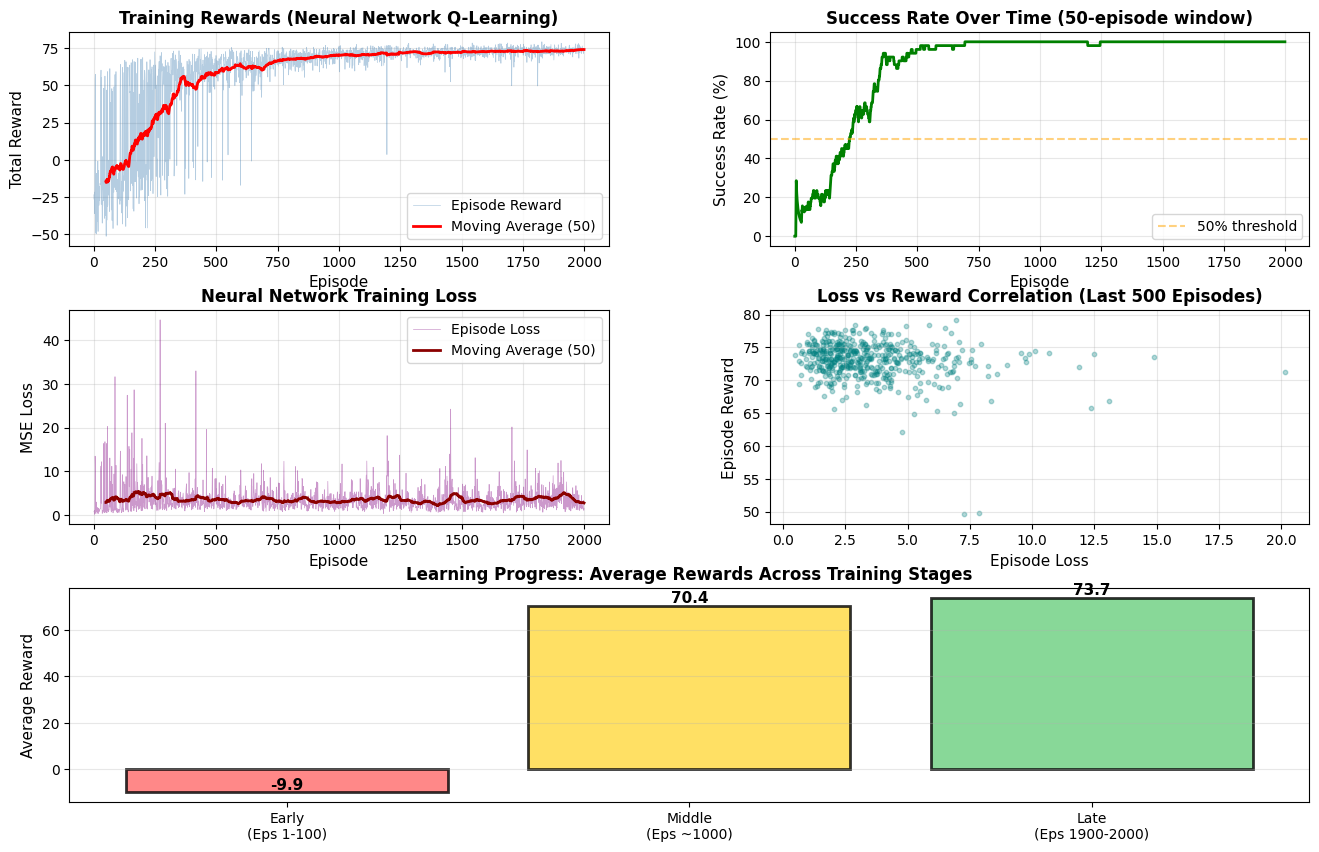


TESTING TRAINED AGENT ON NEW RANDOM GOALS
Goals for this episode: [(2, 6), (5, 2), (8, 1)]
Path length: 25 steps
Goals collected: 3/3

Creating visualization frames...
Saving GIF...
GIF saved as 'rl_agent_neural.gif'



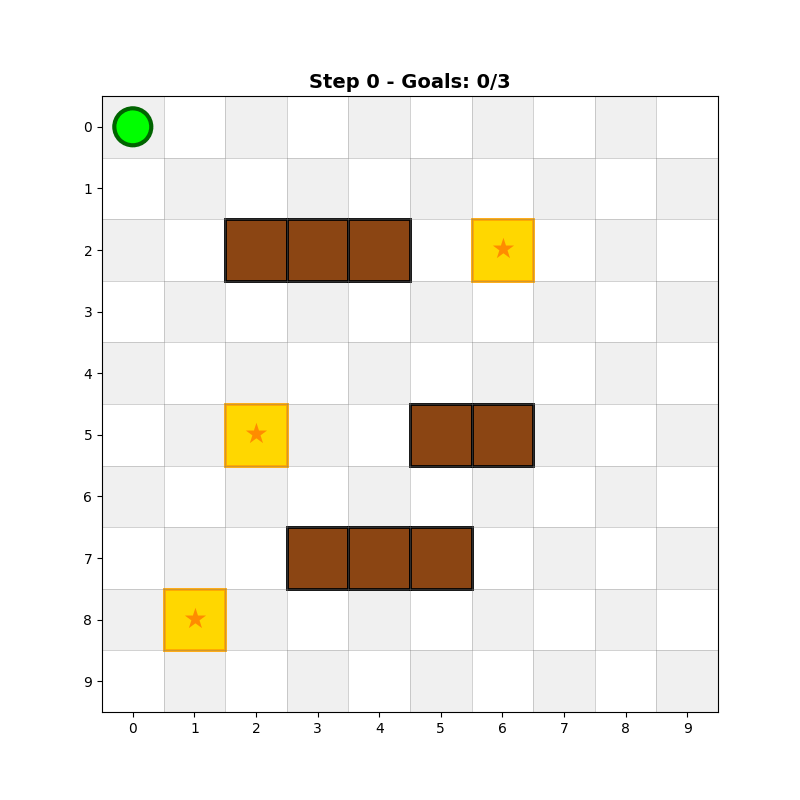


Creating step-by-step progression...


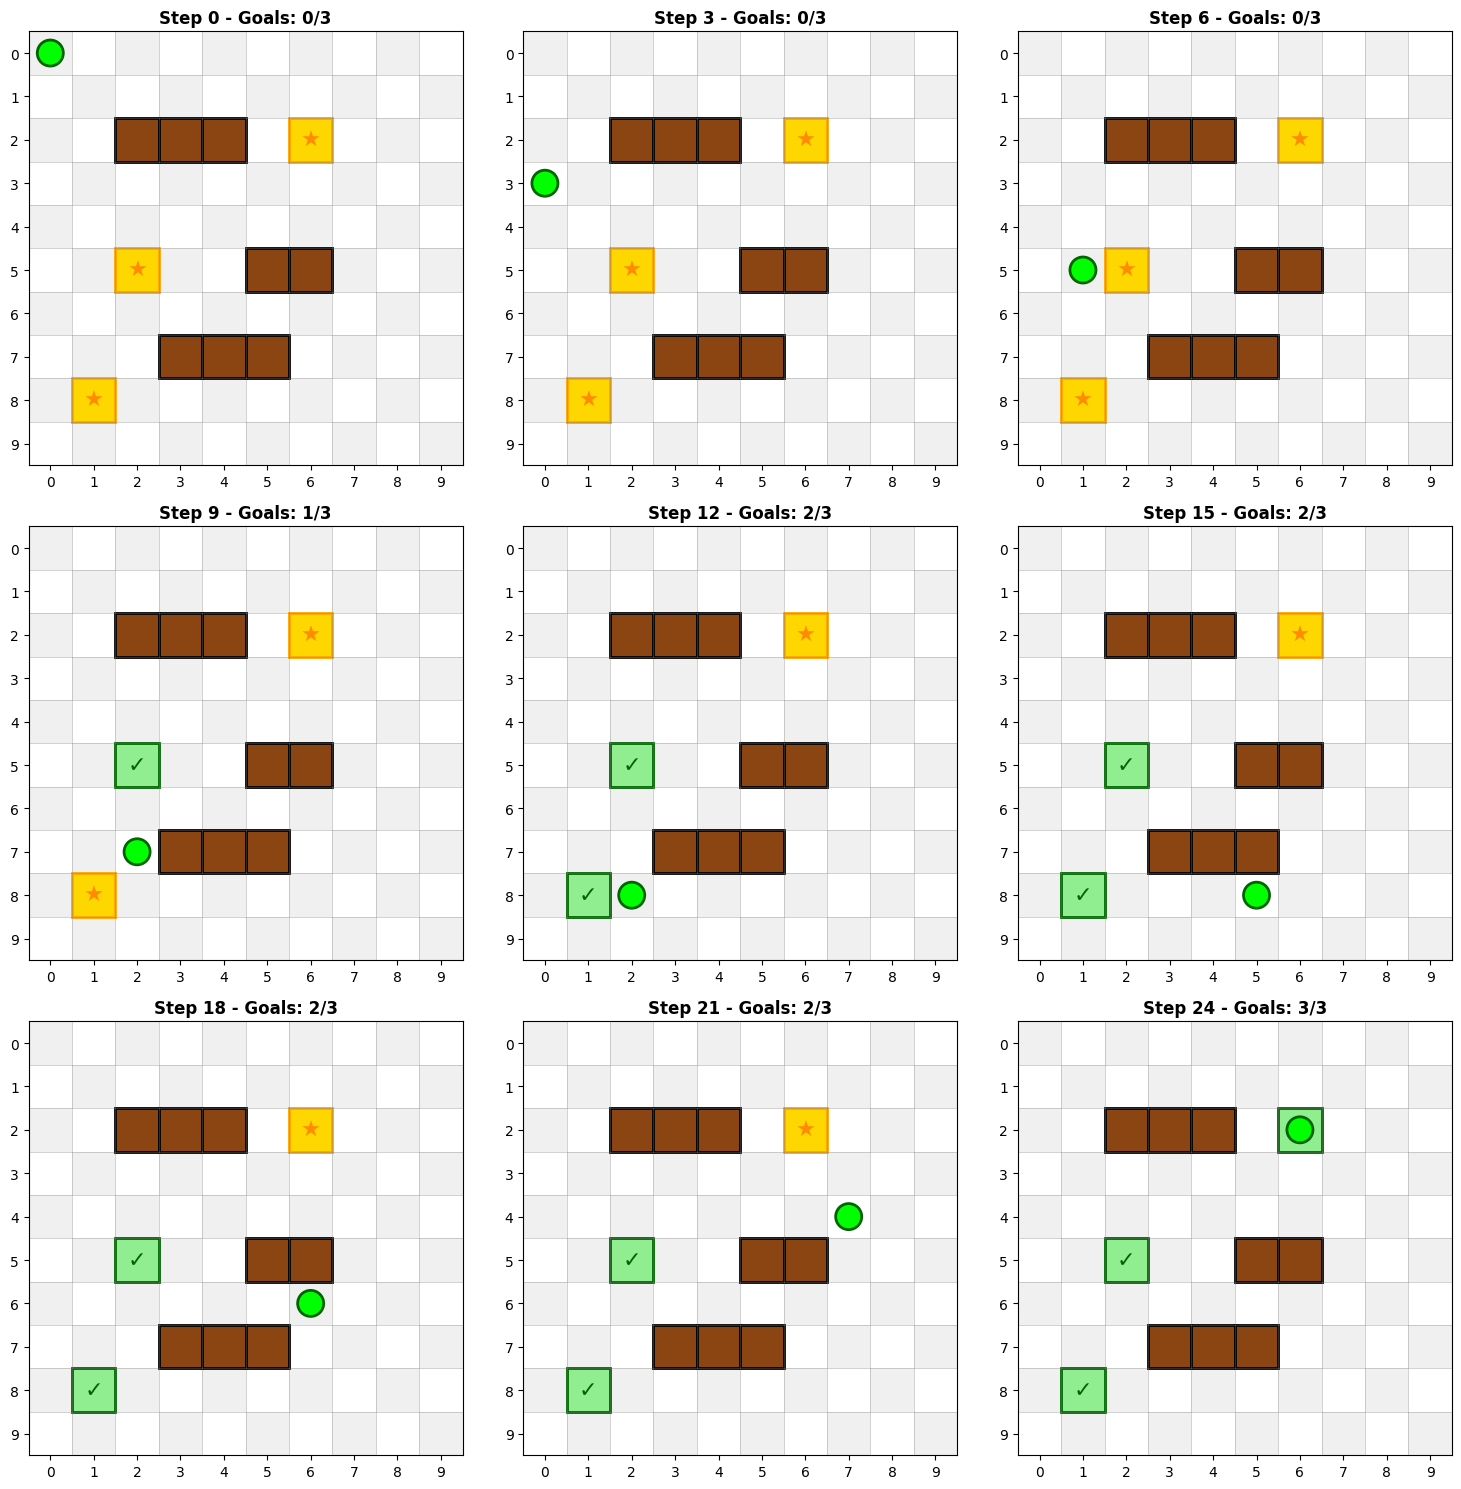


SUMMARY: NEURAL NETWORK Q-LEARNING
✓ Used neural network to approximate Q(s,a)
✓ Network input: 10-dimensional feature vector
✓ Architecture: 10 -> 128 -> 128 -> 4
✓ Optimizer: Adam with learning rate 0.001
✓ Loss function: MSE between predicted and target Q-values
✓ Final success rate: 100.0%
✓ Final average reward: 73.74


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import imageio
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    """Neural network to approximate Q-values"""
    def __init__(self, state_dim, n_actions, hidden_size=128):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.network(x)

class DynamicGridWorldRLNeural:
    def __init__(self, grid_size=10):
        self.grid_size = grid_size

        # Define obstacles (fixed)
        self.obstacles = [(2, 2), (2, 3), (2, 4), (5, 5), (5, 6), (7, 3), (7, 4), (7, 5)]

        # Goals will change every episode
        self.goals = []
        self.collected_goals = set()
        self.agent_pos = [0, 0]

        # Actions: up, down, left, right
        self.actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.n_actions = len(self.actions)

        # Neural network for Q-value approximation
        self.state_dim = 10  # We'll create a feature vector
        self.q_network = QNetwork(self.state_dim, self.n_actions, hidden_size=128)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

        self.discount_factor = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.9995
        self.epsilon_min = 0.01

        # For tracking
        self.loss_history = []

    def _generate_random_goals(self, num_goals=3):
        """Generate random goal positions avoiding obstacles and start"""
        goals = []
        forbidden = set(self.obstacles + [(0, 0)])

        while len(goals) < num_goals:
            x = np.random.randint(0, self.grid_size)
            y = np.random.randint(0, self.grid_size)
            if (x, y) not in forbidden and (x, y) not in goals:
                goals.append((x, y))

        return goals

    def get_nearest_uncollected_goal(self):
        """Find the nearest uncollected goal"""
        uncollected = [g for g in self.goals if tuple(g) not in self.collected_goals]
        if not uncollected:
            return None

        distances = [abs(self.agent_pos[0] - g[0]) + abs(self.agent_pos[1] - g[1])
                    for g in uncollected]
        return uncollected[np.argmin(distances)]

    def get_state_features(self):
        """
        Create a feature vector for neural network input:
        - Normalized agent position (2 features)
        - Normalized relative position to nearest goal (2 features)
        - Distance to nearest goal (1 feature)
        - Number of goals collected / total goals (1 feature)
        - Is on obstacle boundary (4 features: up, down, left, right)
        """
        x, y = self.agent_pos

        # Normalize position
        norm_x = x / self.grid_size
        norm_y = y / self.grid_size

        # Get nearest uncollected goal
        nearest_goal = self.get_nearest_uncollected_goal()

        if nearest_goal is None:
            # All goals collected
            rel_x, rel_y, distance = 0, 0, 0
        else:
            # Relative position to goal (normalized)
            rel_x = (nearest_goal[0] - x) / self.grid_size
            rel_y = (nearest_goal[1] - y) / self.grid_size
            # Normalized manhattan distance
            distance = (abs(nearest_goal[0] - x) + abs(nearest_goal[1] - y)) / (2 * self.grid_size)

        # Progress
        progress = len(self.collected_goals) / len(self.goals) if self.goals else 0

        # Obstacle proximity (binary: 1 if obstacle/wall in that direction, 0 otherwise)
        obstacle_up = 1 if not self.is_valid_pos([x-1, y]) else 0
        obstacle_down = 1 if not self.is_valid_pos([x+1, y]) else 0
        obstacle_left = 1 if not self.is_valid_pos([x, y-1]) else 0
        obstacle_right = 1 if not self.is_valid_pos([x, y+1]) else 0

        features = np.array([
            norm_x, norm_y,           # Position (2)
            rel_x, rel_y,             # Relative to goal (2)
            distance,                 # Distance to goal (1)
            progress,                 # Collection progress (1)
            obstacle_up,              # Obstacle sensors (4)
            obstacle_down,
            obstacle_left,
            obstacle_right
        ], dtype=np.float32)

        return features

    def reset(self):
        """Reset environment with NEW random goals every episode"""
        self.agent_pos = [0, 0]
        self.goals = self._generate_random_goals(num_goals=3)
        self.collected_goals = set()
        return self.get_state_features()

    def is_valid_pos(self, pos):
        x, y = pos
        return (0 <= x < self.grid_size and
                0 <= y < self.grid_size and
                tuple(pos) not in self.obstacles)

    def step(self, action_idx):
        action = self.actions[action_idx]
        new_pos = [self.agent_pos[0] + action[0], self.agent_pos[1] + action[1]]

        # Get distance to nearest goal before move
        nearest_goal = self.get_nearest_uncollected_goal()
        old_dist = float('inf')
        if nearest_goal is not None:
            old_dist = abs(self.agent_pos[0] - nearest_goal[0]) + abs(self.agent_pos[1] - nearest_goal[1])

        reward = -0.1
        done = False

        # Check if new position is valid
        if self.is_valid_pos(new_pos):
            self.agent_pos = new_pos

            # Reward shaping
            if nearest_goal is not None:
                new_dist = abs(self.agent_pos[0] - nearest_goal[0]) + abs(self.agent_pos[1] - nearest_goal[1])
                if new_dist < old_dist:
                    reward += 0.5
                elif new_dist > old_dist:
                    reward -= 0.3

            # Check if agent reached a goal
            if tuple(self.agent_pos) in self.goals and tuple(self.agent_pos) not in self.collected_goals:
                self.collected_goals.add(tuple(self.agent_pos))
                reward = 10.0

                if len(self.collected_goals) == len(self.goals):
                    reward = 50.0
                    done = True
        else:
            # Hit obstacle or wall
            reward = -1.0

        return self.get_state_features(), reward, done

    def get_q_values(self, state):
        """Get Q-values from neural network"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return q_values.numpy()[0]

    def choose_action(self, state, use_epsilon=True):
        """Epsilon-greedy action selection"""
        if use_epsilon and np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            q_values = self.get_q_values(state)
            return np.argmax(q_values)

    def update_network(self, state, action, reward, next_state, done):
        """Update neural network using Q-learning update rule"""
        # Convert to tensors
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        # Current Q-value prediction
        current_q_values = self.q_network(state_tensor)
        current_q = current_q_values[0, action]

        # Target Q-value
        with torch.no_grad():
            next_q_values = self.q_network(next_state_tensor)
            max_next_q = torch.max(next_q_values)

            if done:
                target_q = reward
            else:
                target_q = reward + self.discount_factor * max_next_q

        # Compute loss
        target_q_tensor = torch.FloatTensor([target_q])
        loss = self.loss_fn(current_q, target_q_tensor)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, episodes=2000, max_steps=200):
        rewards_history = []
        success_history = []
        episode_losses = []

        for episode in range(episodes):
            state = self.reset()
            total_reward = 0
            episode_loss = []

            for step in range(max_steps):
                action = self.choose_action(state, use_epsilon=True)
                next_state, reward, done = self.step(action)

                # Update neural network
                loss = self.update_network(state, action, reward, next_state, done)
                episode_loss.append(loss)

                state = next_state
                total_reward += reward

                if done:
                    success_history.append(1)
                    break
            else:
                success_history.append(0)

            rewards_history.append(total_reward)
            episode_losses.append(np.mean(episode_loss))

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                success_rate = np.mean(success_history[-100:]) * 100
                avg_loss = np.mean(episode_losses[-100:])
                print(f"Episode {episode + 1}/{episodes} - Avg Reward: {avg_reward:.2f} - "
                      f"Success Rate: {success_rate:.1f}% - Loss: {avg_loss:.4f} - Epsilon: {self.epsilon:.3f}")

        return rewards_history, success_history, episode_losses

    def visualize_episode(self, max_steps=100):
        """Run one episode with the trained agent and return path"""
        state = self.reset()
        path = [self.agent_pos.copy()]
        goals_collected_timeline = [self.collected_goals.copy()]
        episode_goals = self.goals.copy()

        for _ in range(max_steps):
            action = self.choose_action(state, use_epsilon=False)
            state, reward, done = self.step(action)
            path.append(self.agent_pos.copy())
            goals_collected_timeline.append(self.collected_goals.copy())

            if done:
                break

        return path, goals_collected_timeline, episode_goals

# Train the agent
print("=" * 70)
print("Q-LEARNING WITH NEURAL NETWORK APPROXIMATION")
print("=" * 70)
print("Using a neural network to approximate Q(s,a) instead of a Q-table!")
print("Network architecture: Input(10) -> Hidden(128) -> Hidden(128) -> Output(4)")
print("State features: position, goal direction, distance, progress, obstacles")
print("=" * 70)
print()

env = DynamicGridWorldRLNeural(grid_size=10)
rewards, successes, losses = env.train(episodes=2000, max_steps=200)

# Create comprehensive plots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Training rewards
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(rewards, alpha=0.4, linewidth=0.5, color='steelblue', label='Episode Reward')
window = 50
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(rewards)), moving_avg, color='red', linewidth=2, label='Moving Average (50)')
ax1.set_xlabel('Episode', fontsize=11)
ax1.set_ylabel('Total Reward', fontsize=11)
ax1.set_title('Training Rewards (Neural Network Q-Learning)', fontsize=12, weight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Success rate
ax2 = fig.add_subplot(gs[0, 1])
success_rate = [np.mean(successes[max(0, i-50):i+1]) * 100 for i in range(len(successes))]
ax2.plot(success_rate, color='green', linewidth=2)
ax2.set_xlabel('Episode', fontsize=11)
ax2.set_ylabel('Success Rate (%)', fontsize=11)
ax2.set_title('Success Rate Over Time (50-episode window)', fontsize=12, weight='bold')
ax2.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50% threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Training loss
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(losses, alpha=0.4, linewidth=0.5, color='purple', label='Episode Loss')
loss_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
ax3.plot(range(window-1, len(losses)), loss_avg, color='darkred', linewidth=2, label='Moving Average (50)')
ax3.set_xlabel('Episode', fontsize=11)
ax3.set_ylabel('MSE Loss', fontsize=11)
ax3.set_title('Neural Network Training Loss', fontsize=12, weight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Rewards vs Loss correlation (last 500 episodes)
ax4 = fig.add_subplot(gs[1, 1])
recent_window = min(500, len(rewards))
ax4.scatter(losses[-recent_window:], rewards[-recent_window:], alpha=0.3, s=10, color='teal')
ax4.set_xlabel('Episode Loss', fontsize=11)
ax4.set_ylabel('Episode Reward', fontsize=11)
ax4.set_title('Loss vs Reward Correlation (Last 500 Episodes)', fontsize=12, weight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Learning progress comparison
ax5 = fig.add_subplot(gs[2, :])
episodes_range = np.arange(len(rewards))
early_rewards = np.mean(rewards[:100]) if len(rewards) >= 100 else np.mean(rewards)
mid_rewards = np.mean(rewards[len(rewards)//2-50:len(rewards)//2+50]) if len(rewards) >= 100 else np.mean(rewards)
late_rewards = np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)

stages = ['Early\n(Eps 1-100)', 'Middle\n(Eps ~1000)', 'Late\n(Eps 1900-2000)']
avg_rewards_stages = [early_rewards, mid_rewards, late_rewards]
colors_bar = ['#ff6b6b', '#ffd93d', '#6bcf7f']

bars = ax5.bar(stages, avg_rewards_stages, color=colors_bar, edgecolor='black', linewidth=2, alpha=0.8)
ax5.set_ylabel('Average Reward', fontsize=11)
ax5.set_title('Learning Progress: Average Rewards Across Training Stages', fontsize=12, weight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, avg_rewards_stages):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}',
             ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("TESTING TRAINED AGENT ON NEW RANDOM GOALS")
print("=" * 70)

# Visualize the trained agent with NEW goals
path, goals_timeline, episode_goals = env.visualize_episode(max_steps=150)
print(f"Goals for this episode: {episode_goals}")
print(f"Path length: {len(path)} steps")
print(f"Goals collected: {len(goals_timeline[-1])}/{len(episode_goals)}")

def draw_grid(agent_pos, collected_goals, step_num, goals, env):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Checkered background
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i % 2 + j % 2) % 2 == 0:
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor='#f0f0f0', edgecolor='none'))

    # Draw obstacles
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                               facecolor='#8b4513', edgecolor='black', linewidth=2))

    # Draw goals
    for goal in goals:
        if tuple(goal) in collected_goals:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#90EE90', edgecolor='darkgreen', linewidth=2))
            ax.text(goal[1], goal[0], '✓', fontsize=20, ha='center', va='center',
                   color='darkgreen', weight='bold')
        else:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#FFD700', edgecolor='orange', linewidth=2))
            ax.text(goal[1], goal[0], '★', fontsize=20, ha='center', va='center',
                   color='darkorange')

    # Draw agent
    circle = plt.Circle((agent_pos[1], agent_pos[0]), 0.3,
                       facecolor='#00FF00', edgecolor='darkgreen', linewidth=3, zorder=10)
    ax.add_patch(circle)

    # Grid lines
    for i in range(env.grid_size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)

    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_title(f'Step {step_num} - Goals: {len(collected_goals)}/{len(goals)}',
                fontsize=14, weight='bold')
    ax.grid(False)

    return fig

# Save frames as GIF
print("\nCreating visualization frames...")
frames = []

for i in range(0, len(path), 2):
    fig = draw_grid(path[i], goals_timeline[i], i, episode_goals, env)
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    frames.append(image[:, :, :3])
    plt.close(fig)

print("Saving GIF...")
imageio.mimsave('rl_agent_neural.gif', frames, fps=5, loop=0)
print("GIF saved as 'rl_agent_neural.gif'")

# Embed GIF
from IPython.display import HTML, display
import base64

with open('rl_agent_neural.gif', 'rb') as f:
    gif_data = f.read()
    gif_base64 = base64.b64encode(gif_data).decode()

display(HTML(f'<img src="data:image/gif;base64,{gif_base64}" />'))

# Step-by-step snapshots
print("\nCreating step-by-step progression...")
num_snapshots = min(9, len(path))
step_indices = np.linspace(0, len(path)-1, num_snapshots, dtype=int)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for idx, step_idx in enumerate(step_indices):
    ax = axes[idx]
    ax.set_xlim(-0.5, env.grid_size - 0.5)
    ax.set_ylim(-0.5, env.grid_size - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    # Checkered background
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if (i % 2 + j % 2) % 2 == 0:
                ax.add_patch(Rectangle((j - 0.5, i - 0.5), 1, 1,
                                      facecolor='#f0f0f0', edgecolor='none'))

    # Obstacles
    for obs in env.obstacles:
        ax.add_patch(Rectangle((obs[1] - 0.5, obs[0] - 0.5), 1, 1,
                               facecolor='#8b4513', edgecolor='black', linewidth=2))

    # Goals
    for goal in episode_goals:
        if tuple(goal) in goals_timeline[step_idx]:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#90EE90', edgecolor='darkgreen', linewidth=2))
            ax.text(goal[1], goal[0], '✓', fontsize=16, ha='center', va='center',
                   color='darkgreen', weight='bold')
        else:
            ax.add_patch(Rectangle((goal[1] - 0.5, goal[0] - 0.5), 1, 1,
                                   facecolor='#FFD700', edgecolor='orange', linewidth=2))
            ax.text(goal[1], goal[0], '★', fontsize=16, ha='center', va='center',
                   color='darkorange')

    # Agent
    circle = plt.Circle((path[step_idx][1], path[step_idx][0]), 0.3,
                       facecolor='#00FF00', edgecolor='darkgreen', linewidth=2, zorder=10)
    ax.add_patch(circle)

    # Grid lines
    for i in range(env.grid_size + 1):
        ax.axhline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)
        ax.axvline(i - 0.5, color='gray', linewidth=0.5, alpha=0.5)

    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_title(f'Step {step_idx} - Goals: {len(goals_timeline[step_idx])}/{len(episode_goals)}',
                fontsize=12, weight='bold')
    ax.grid(False)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("SUMMARY: NEURAL NETWORK Q-LEARNING")
print("=" * 70)
print(f"✓ Used neural network to approximate Q(s,a)")
print(f"✓ Network input: 10-dimensional feature vector")
print(f"✓ Architecture: 10 -> 128 -> 128 -> 4")
print(f"✓ Optimizer: Adam with learning rate 0.001")
print(f"✓ Loss function: MSE between predicted and target Q-values")
print(f"✓ Final success rate: {np.mean(successes[-100:])*100:.1f}%")
print(f"✓ Final average reward: {np.mean(rewards[-100:]):.2f}")
print("=" * 70)